**Prepare training dataset from penelope results. Run the aux functions first.**


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Random tile for training data generation

In [ ]:
np.linspace(0, 0.1,51)

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
       0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
       0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
       0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  ])

In [ ]:
# Generate images for sparsity from ~0 to 0.1

# Load the image stack of single event
raw = Image.open('/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/200kV_98000electron.tif')

filenumber = 0
imgsize = 64 ########
for sparsity in np.linspace(0, 0.1,51):

  slist = np.linspace(sparsity, sparsity + 0.002,11)[1:]
  repeat = 20 ######### defines how many images will be generated within this sparisity range
  truth_all = np.zeros((10,repeat,imgsize,imgsize))
  tiled_all = np.zeros((10,repeat,imgsize,imgsize))

  imgfiles = []
  boxfiles = []

  # dark noise added from a exp dark frame
  dark = Image.open('/content/drive/MyDrive/CNN e-detect for Celeritas/Black noise/1000fps_fullRolling.tif')

  for i in range(len(slist)):
    for rp in range(repeat):
      _, img, boxes = randomtile(rawimagestack = raw, sparsity = slist[i], returnBoxMask=True, imgsize= 64)

      # gaussian noise
      img = noisy('gauss',img)
      # dark noise
      frame = np.random.randint(0,10)
      dark.seek(frame)
      rawdata = np.array(dark) # the only way to make the data writable
      source = deadcorr(rawdata)
      random.shuffle(source)

      img = img + source[512:512+imgsize, 512:512+imgsize]
      imgfiles.append(img)
      boxfiles.append(boxes)
  path = '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/TrainingData/' ##########
  np.savez(path+ f"{filenumber:03}" +'_img.npz',*imgfiles)
  np.savez(path+ f"{filenumber:03}" +'_box.npz',*boxfiles)

  print('Done stack,', filenumber)
  filenumber = filenumber + 1


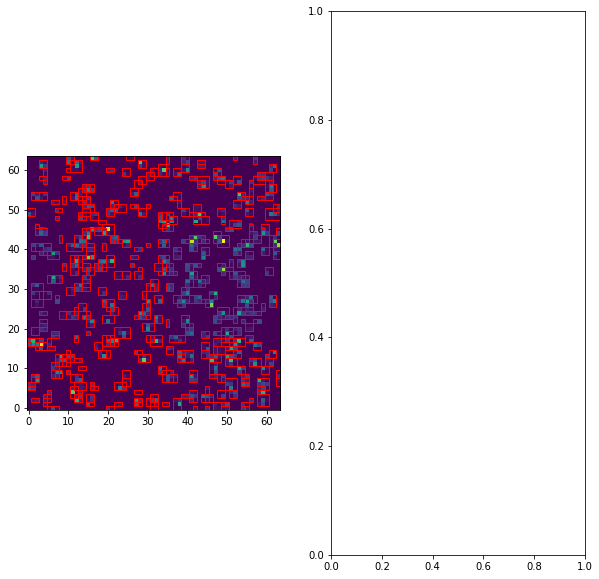

In [ ]:
import matplotlib.patches as patches
img = np.load(path+ f"{(filenumber-1):03}" +'_img.npz')
box = np.load(path+ f"{(filenumber-1):03}" +'_box.npz')

fig =  plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(img['arr_100'], origin='lower')
for box in box['arr_100']:
  ymin, xmin, ymax, xmax = box
  rect = patches.Rectangle((xmin - 0.5, ymin - 0.5), xmax - xmin+1, ymax - ymin+1, linewidth=1, edgecolor='r',
                            facecolor='none')
  ax1.add_patch(rect)

# ax2.imshow(truth_all, origin='lower')
# for box in boxall:
#   ymin, xmin, ymax, xmax = box
#   ymax = ymax+1
#   xmax = xmax+1
#   ymin, xmin, ymax, xmax = ymin*2, xmin*2, ymax*2, xmax*2
#   rect = patches.Rectangle((xmin - 0.5, ymin - 0.5), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r',
#                             facecolor='none')
#   ax2.add_patch(rect)
plt.show()


Mostly, Sparsity>= 0.05 max count = 3

0.02>Sparsity>= 0.002 max count = 2

Sparsity < 0.002 max count = 1

# AUX functions


In [ ]:
def randomtile(rawimagestack, sparsity, returnBoxMask = False, imgsize= 64):
  '''
  This function create images with random electron event distribution.
  sparsity: # e-/px
  imgsize: the size of output images.
  '''
  rawimagestack.seek(0)
  w = np.asarray(rawimagestack).shape[0]
  wh = int((w-1)/2)

  count = int(np.ceil(imgsize*imgsize*sparsity))# number of electrons in a image
  #print('Electons: ', count)
  posx = np.random.randint(0,imgsize,size=count)
  posy = np.random.randint(0,imgsize,size=count)

  groundtruth = np.zeros((imgsize,imgsize))
  for i in range(len(posx)):
    groundtruth[posx[i],posy[i]] += 1

  tileimage = np.zeros((imgsize+w-1,imgsize+w-1))
  # masks = np.zeros((len(posx), 15,15))
  boxes = np.zeros((len(posx), 4))

  for patch in range(len(posx)):
    index = random.randrange(0, 98000, 1) # number of image in the rawstack!!
    rawimagestack.seek(index)
    rawdata = np.asarray(rawimagestack)
    while rawdata.max()<=20:
      index = random.randrange(0, 98000, 1) # number of image in the rawstack!!
      rawimagestack.seek(index)
      rawdata = np.asarray(rawimagestack)

    rawdata = np.clip(rawdata, a_min=0, a_max = None)

    tileimage[posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] = tileimage[posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] + rawdata
    if returnBoxMask==True:
      #masks[patch][posx[patch]:posx[patch]+w, posy[patch]:posy[patch]+w] = rawdata>20  # threshold is set to 20.
      x, y = np.where(rawdata>20)
      # masks[patch][:(1+x.max()-x.min()), :(1+y.max()-y.min())] = rawdata[x.min():(x.max()+1), y.min():(y.max()+1)]>0
      boxes[patch] = (x.min()+posx[patch]-wh, y.min()+posy[patch]-wh,
                      x.max()+posx[patch]-wh, y.max()+posy[patch]-wh)

  if returnBoxMask==True:
      return groundtruth, tileimage[wh:imgsize+wh,wh:imgsize+wh],boxes
  else:
    return groundtruth, tileimage[wh:imgsize+wh,wh:imgsize+wh]

In [ ]:
def noisy(noise_typ,image): #defining a function to add noise to the images
   if noise_typ == "gauss":
      row,col,= image.shape
      mean = 0             #taken from sparse frames of celeritas histogram . mean = -0.17  .RMSD = 1.319
      var = 0.0001           #square of the standard deviation from sparse frames histogram
      sigma = var**0.5
      threshold = 8 #8ADU
      gauss = np.random.normal(mean,sigma,(row,col))     #thresholding instead of adding noise
      tnoisy = image + gauss                            #just making sure they're not exactly the same

      for x in range(row):                    #Noise thresholding so that only positive noise is added to the empty pixels
             for y in range(col):
                                                #each pixel should be an integer, not a floating point. Round each pixel after noise is added.
                 if tnoisy[x][y] < threshold:      #trying not to wipe out smaller contributions
                     tnoisy[x][y] = 0

      noisy = np.round(tnoisy) #+ gauss)    #adding noise after thresholding to recreate the image
      return noisy

In [ ]:
def deadcorr(raw):
  '''
  This function corrects the dead pixel within the dark reference frame.
  work for current dead pixel correction, interpolate from near position
  '''
  temp = raw
  temp[:,248] = 0.5*temp[:,247] + 0.5*temp[:,246]
  return temp